<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction---Mean-Variance-Optimization-and-Machine-Learning" data-toc-modified-id="Introduction---Mean-Variance-Optimization-and-Machine-Learning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction - Mean Variance Optimization and Machine Learning</a></span></li><li><span><a href="#Setup-and-Data-Imports" data-toc-modified-id="Setup-and-Data-Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup and Data Imports</a></span><ul class="toc-item"><li><span><a href="#Risk-Free-Rate" data-toc-modified-id="Risk-Free-Rate-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Risk-Free Rate</a></span></li><li><span><a href="#Portfolio-Allocations-and-ETF-Returns" data-toc-modified-id="Portfolio-Allocations-and-ETF-Returns-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Portfolio Allocations and ETF Returns</a></span></li></ul></li><li><span><a href="#ETF-Return-Predictions-with-KNN" data-toc-modified-id="ETF-Return-Predictions-with-KNN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ETF Return Predictions with KNN</a></span><ul class="toc-item"><li><span><a href="#Periods-by-Month" data-toc-modified-id="Periods-by-Month-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Periods by Month</a></span></li><li><span><a href="#Generate-Predicted-Monthly-Returns" data-toc-modified-id="Generate-Predicted-Monthly-Returns-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generate Predicted Monthly Returns</a></span></li></ul></li><li><span><a href="#Multi-Period-Optimization-Using-Mean-Variance-Framework" data-toc-modified-id="Multi-Period-Optimization-Using-Mean-Variance-Framework-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Multi-Period Optimization Using Mean-Variance Framework</a></span><ul class="toc-item"><li><span><a href="#Historical-Optimized-Portfolios" data-toc-modified-id="Historical-Optimized-Portfolios-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Historical Optimized Portfolios</a></span></li></ul></li><li><span><a href="#Performance-Evaluation" data-toc-modified-id="Performance-Evaluation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Performance Evaluation</a></span><ul class="toc-item"><li><span><a href="#Single-Portfolio-Comparison" data-toc-modified-id="Single-Portfolio-Comparison-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Single Portfolio Comparison</a></span></li><li><span><a href="#Evaluating-Optimizations-of-All-Portfolios" data-toc-modified-id="Evaluating-Optimizations-of-All-Portfolios-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Evaluating Optimizations of All Portfolios</a></span></li></ul></li><li><span><a href="#Optimization-Using-All-ETFs" data-toc-modified-id="Optimization-Using-All-ETFs-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Optimization Using All ETFs</a></span></li><li><span><a href="#Discussion-and-Next-Steps" data-toc-modified-id="Discussion-and-Next-Steps-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Discussion and Next Steps</a></span></li></ul></div>

# Introduction - Mean Variance Optimization and Machine Learning

This project combines multi-period mean-variance optimization through the Markowitz efficient frontier and time series forecasting through the k-nearest neighbors (KNN) algorithm. The process of building an efficient frontier relies on historical covariances and expected returns. Previously, return predictions were made using historical average investment returns. Backtesting the optimization process resulted in higher risk-adjusted portfolio returns, but the strategy underperformed a portfolio weighted 60% to U.S. equities and 40% to U.S. credit.

To address the weakness in return forecasting, this project employs the KNN algorithm with time series complexity adjustments and normalization. Normalization allows for comparisons to previous sub-series. Complexity adjustments scale the Euclidean distance metric so that the values of the sub-series are not the only determinant of distance.

More information about implementing KNN for time series [is available in this repository.](https://github.com/mem692/knn_tspi)

More information about this project's implementation of mean-variance optimization [is available in this repository.](https://github.com/mem692/eff_frontier)

To test KNN and multi-period optimizations, this project uses portfolio allocations aggregated by [Portfolio Charts.](https://portfoliocharts.com/portfolios/) Portfolio Charts has tested allocations recommended across many different publications. This project answers the question - given the same investments, can machine learning and optimization create better performing portfolios?

Assumptions made in this analysis:

* The hypothetical investor making allocation decisions rebalances their portfolio on a monthly basis
* The portfolio is long only
* The investor is unable to borrow at the risk-free rate
* The portfolio has no frictional costs

# Setup and Data Imports

Previous projects (see Introduction) include three custom classes imported for this analysis:

* EffFrontier includes helper functions for building and extracting portfolios that are optimized in the mean-variance framework
* PortStats includes calculations for performance evaluation and comparison
* TimeSeriesKNN includes helper functions for implementing KNN-TSPI

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from seaborn import color_palette
colors = color_palette('deep')
from IPython.display import display, HTML
from mpt_stats import EffFrontier, PortStats
from knn_tspi import TimeSeriesKNN

## Risk-Free Rate

A risk-free proxy for performance evaluation comes from the Federal Reserve Economic Data (FRED). This data uses the three-month Treasury bill secondary market rates. The rates are de-annualized and converted to monthly "returns." This methodology is used by various data providers, such as FTSE and MSCI, to calculate indexes for risk-free proxies.

In [2]:
risk_free = pd.read_csv('Data/3MTBILL_Monthly.csv', header=0)
risk_free = risk_free.set_index('date', drop=True).pivot(
    columns='id', values='mon_return').multiply(100)
risk_free.index = pd.to_datetime(risk_free.index)

## Portfolio Allocations and ETF Returns

Asset allocations from Portfolio Charts use ETF proxies. The 'PortfolioWeights.csv' file stores these allocations.

Return history for the ETFs come from freely available Alpha Vantage data. Data was pre-processed and stored in CSV files for retrieval.

In [3]:
port_allocs = pd.read_csv('Data\PortfolioWeights.csv')
etf_list = list(port_allocs['ETF'])
etf_daily_history = pd.read_csv('Data\etf_daily_history.csv')
etf_daily_history['date'] = pd.to_datetime(etf_daily_history['date'])
etf_daily_history = etf_daily_history.pivot(
    index='date', columns='security', values='value')
etf_monthly_history = pd.read_csv('Data\etf_monthly_history.csv')
etf_monthly_history['date'] = pd.to_datetime(etf_monthly_history['date'])
etf_monthly_history = etf_monthly_history.pivot(
    index='date', columns='security', values='mon_return')

The below dictionary stores weights and ETF components for selected portfolios. Portfolio Charts does not publish specific ETFs or index data used in their analysis but instead suggest some index funds. The ETFs in this project are simply representative ETFs with the longest history of returns. 

For example, many ETFs track the U.S. stock market and can be used for the Total Stock Market asset class. This project uses VTI because VTI has the longest track record available. The same applies for GLD for Gold, TLT for long-term treasuries, etc. The below cell lists the asset classes, ETF proxies, and weights used for the various portfolios.

For some portfolios, Portfolio Charts indicates that the official recommended allocation includes inflation-protected securities, but their analysis does not use a proxy due to lack of available data. This project uses TIP (iShares TIPS Bond ETF) as a proxy for Treasury inflation-protected securities.

In [4]:
port_alloc_dict = {}

for port in port_allocs.columns[2:]:
    df = port_allocs[['Asset Class','ETF',port]].dropna(axis=0,how='any')
    etfs = df['ETF'].to_list()
    weights = df[port].to_numpy()
    port_dict = {'etfs': etfs, 'weights': weights/100}
    port_alloc_dict[port] = port_dict
    display(HTML(df.to_html(index=False)))

Asset Class,ETF,Permanent Portfolio
US Total Stock Market,VTI,25.0
Long-Term Treasuries,TLT,25.0
Ultra-Short Treasuries,BIL,25.0
Gold,GLD,25.0


Asset Class,ETF,Three Fund Portfolio
US Total Stock Market,VTI,40.0
International Stocks,VEA,20.0
US Fixed Income,AGG,40.0


Asset Class,ETF,Pinwheel Portfolio
US Total Stock Market,VTI,15.0
US Small Cap Value,IJS,10.0
International Stocks,VEA,15.0
Emerging Markets Stocks,VWO,10.0
Intermediate Treasuries,IEI,15.0
Ultra-Short Treasuries,BIL,10.0
Real Estate,IYR,15.0
Gold,GLD,10.0


Asset Class,ETF,All Seasons Portfolio
US Total Stock Market,VTI,30.0
Long-Term Treasuries,TLT,40.0
Intermediate Treasuries,IEI,15.0
Commodities,DBC,7.5
Gold,GLD,7.5


Asset Class,ETF,Golden Butterfly
US Total Stock Market,VTI,20.0
US Small Cap Value,IJS,20.0
Long-Term Treasuries,TLT,20.0
Short-Term Treasuries,SHY,20.0
Gold,GLD,20.0


Asset Class,ETF,Coffeehouse Portfolio
US Large Cap Blend,SPY,10.0
US Large Cap Value,SPYV,10.0
US Mid Cap Blend,MDY,10.0
US Mid Cap Value,IJJ,10.0
International Stocks,VEA,10.0
Intermediate Treasuries,IEI,40.0
Real Estate,IYR,10.0


Asset Class,ETF,Swensen Portfolio
US Total Stock Market,VTI,30.0
International Stocks,VEA,15.0
Emerging Markets Stocks,VWO,5.0
Intermediate Treasuries,IEI,15.0
Inflation-Protected,TIP,15.0
Real Estate,IYR,20.0


Asset Class,ETF,7Twelve Portfolio
US Large Cap Blend,SPY,8.3
US Mid Cap Blend,MDY,8.3
US Small Cap Blend,IJR,8.3
International Stocks,VEA,8.3
Emerging Markets Stocks,VWO,8.3
Intermediate Treasuries,IEI,8.5
Ultra-Short Treasuries,BIL,8.3
Inflation-Protected,TIP,8.5
Commodities,DBC,16.6
Real Estate,IYR,8.3


Asset Class,ETF,60/40 Portfolio
US Total Stock Market,VTI,60.0
US Fixed Income,AGG,40.0


Asset Class,ETF,Ivy Portfolio
US Total Stock Market,VTI,20.0
International Stocks,VEA,20.0
Intermediate Treasuries,IEI,20.0
Commodities,DBC,20.0
Real Estate,IYR,20.0


The selected portfolios represent a diverse set of allocation decisions. Many heavily weight US equity and credit, but there are a number of portfolios that include international equity issues and commodities. The 60/40 Portfolio and Three Fund Portfolio are 100% and 80% allocated to US equity and credit, respectively. By contrast, the Pinwheel Portfolio and Ivy Portfolio are 50% and 40% allocated to those classes. The remaining allocations are split between international equity, real estate, and commodities. 

For US equity allocations, some portfolios eschew market capitalization weighting of VTI. The 7Twelve Portfolio uses equal weighting among large-, mid-, and small-cap equities. The Coffeehouse Portfolio recommends a value tilt for large- and mid-cap issues only, preferring to reduce small-cap exposure entirely.

# ETF Return Predictions with KNN

Here, we generate ETF monthly return predictions using daily price data. Because each month has a different number of trading days, we cannot use the number of days in a month to predict price movements with KNN. Therefore, we count the number of closing prices for SPY, the ETF with the longest track record, for each month.

## Periods by Month

In [6]:
periods_by_month = etf_daily_history.groupby(pd.Grouper(freq='M'))['SPY'].count()[1:-1]
periods_by_month

date
2000-04-30    19
2000-05-31    22
2000-06-30    22
2000-07-31    20
2000-08-31    23
              ..
2019-10-31    23
2019-11-30    20
2019-12-31    21
2020-01-31    21
2020-02-29    19
Freq: M, Name: SPY, Length: 239, dtype: int64

## Generate Predicted Monthly Returns

To predict monthly returns, the KNN algorithm forecasts the ETF price for the end of the month. It uses the number of periods in that month and resticts the training data to the history available at that time. This gives an accurate picture of what information our hypothetical investor would have at the time of rebalancing each month.

The next cell uses the TimeSeriesKNN class to make these forecasts and store in a pandas dataframe. In this cell and further through the analysis, we use a time frame of 12/31/2009 through 12/31/2019. This is needed to facilitate more informed KNN forecasts. Without additional return history, the KNN algorithm, using the optimized parameters from the previous repository, will be unable to make all predictions well.

In [7]:
date_range = pd.date_range(start = '2010-1-31',end = '2019-12-31', freq = 'M')

etf_pred_series = []
for etf in etf_list:
    pred_list = []
    for i, date in enumerate(date_range):
        start = date - pd.tseries.offsets.MonthEnd()
        periods = periods_by_month[date]
        model_data = etf_daily_history[etf_daily_history.index<=start][etf].dropna()
        model = TimeSeriesKNN(model_data,metric='cid', k=125, length=5, step=periods)
        prediction = model.predict_one()
        start_val = etf_daily_history[etf_daily_history.index<=start][etf][-1]
        pred_return = (prediction/start_val)-1
        pred_list.append(pred_return)
    etf_pred_series.append(pd.Series(data = pred_list, index = date_range, name = etf))
etf_predictions = pd.concat(etf_pred_series,axis=1)
etf_predictions

,VTI,SPY,SPYV,SPYG,MDY,IJJ,IJK,IJR,IJS,IJT,...,TLT,IEI,SHY,BIL,TIP,DBC,IYR,GLD,AGG,BWX
2010-01-31,0.006137,0.003900,0.003899,0.004946,0.009135,0.007921,0.005342,0.004660,-0.000180,0.004816,...,0.006931,0.003332,0.003408,0.000720,0.002547,0.010205,0.021337,0.007477,0.003089,0.004202
2010-02-28,0.007713,0.010633,0.005335,0.011645,0.018248,0.013601,0.014285,0.011490,-0.001206,0.005443,...,0.001964,0.002304,0.001520,0.000496,0.003373,0.003283,0.013251,0.010979,0.001532,0.001855
2010-03-31,0.007080,0.000100,0.006800,-0.003781,0.001703,0.012497,0.001642,0.006830,0.005619,0.003227,...,0.008188,0.008029,0.002067,0.000953,0.003217,0.011844,0.019353,0.018634,0.006124,0.003805
2010-04-30,0.001414,0.001793,0.002652,0.001677,0.003319,0.005726,0.003254,0.006019,0.006886,0.005449,...,-0.000760,0.002269,0.001744,0.000576,0.002120,0.011319,0.006151,0.027111,0.001469,-0.000155
2010-05-31,0.017061,0.005267,0.001118,-0.332071,0.019254,0.019814,0.008937,0.032622,0.012851,0.011501,...,0.006455,0.008335,0.004263,0.000552,0.004870,0.004195,0.030276,0.012681,0.002430,0.000911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,0.011110,0.002919,0.007948,0.002326,0.010764,0.009406,0.012522,0.008177,0.006736,0.002317,...,0.004468,0.000349,0.000315,0.000771,0.002151,0.000658,-0.001912,0.009075,0.000330,0.001008
2019-09-30,0.005309,0.003469,0.015214,0.004018,0.005010,0.019072,0.005055,0.011644,0.008441,0.008271,...,0.013261,0.000669,0.000690,0.000808,0.003729,-0.000986,0.008557,0.004844,0.002388,0.001854
2019-10-31,0.003727,0.004250,0.005487,0.004325,0.009998,0.009105,0.005385,-0.008187,-0.003771,0.005283,...,0.008997,0.004069,0.001887,0.000943,0.004044,-0.005210,0.003592,0.028243,0.003127,0.003625
2019-11-30,0.005450,0.005375,0.001741,0.006476,0.004705,0.004168,0.005636,0.009367,-0.000023,0.009438,...,0.017977,0.003307,0.002651,0.001277,0.005571,-0.005575,0.009045,0.003600,0.005385,0.001148


# Multi-Period Optimization Using Mean-Variance Framework

Now that we have return predictions for each ETF, we can generate mean-variance optimized portfolios for each month. The EffFrontier class includes a method that returns weights for five portfolios along the frontier. We assume our investor can choose between five risk tolerances - conservative, moderately conservative, moderate, moderately aggressive, and aggressive. The difference is the level of portfolio volatility. Each risk tolerance level is a quantile of volatility along the "upper half" of the frontier. A higher risk tolerance is met with a higher expected volatility.

This calculation is performed for the ETFs in each of the Portfolio Charts portfolios. We limit the ETF choices to those in the portfolio to see if mean-variance optimization enhanced by KNN predictions can outperform a static allocation to the ETFs in the portfolio.

## Historical Optimized Portfolios

In [8]:
eff_weights = pd.read_csv('Data\EffPortfolioWeights.csv',header=[0,1],index_col=[0,1])
eff_weights.index = eff_weights.index.set_levels([pd.to_datetime(eff_weights.index.levels[0]),eff_weights.index.levels[1]])
eff_weights

port                Permanent Portfolio                                \
etfs                                VTI       TLT       BIL       GLD   
date       risk                                                         
2010-01-31 cons                0.005775  0.000430  0.993795  0.000000   
           mod_cons            0.092542  0.138783  0.714168  0.054507   
           moder               0.175579  0.270299  0.440857  0.113265   
           mod_agg             0.260232  0.404474  0.161986  0.173309   
           agg                 0.285291  0.482058  0.000000  0.232652   
...                                 ...       ...       ...       ...   
2019-12-31 cons                0.004711  0.001053  0.994236  0.000000   
           mod_cons            0.214796  0.139171  0.646033  0.000000   
           moder               0.420713  0.274414  0.304873  0.000000   
           mod_agg             0.649200  0.350800  0.000000  0.000000   
           agg                 0.863975  0.136025  0.000000  0.000000   

port                Three Fund Portfolio                Pinwheel Portfolio  \
etfs                                 VTI  VEA       AGG                VTI   
date       risk                                                              
2010-01-31 cons                 0.002640  0.0  0.997360           0.003939   
           mod_cons             0.262821  0.0  0.737179           0.000000   
           moder                0.508547  0.0  0.491453           0.000000   
           mod_agg              0.754274  0.0  0.245726           0.000000   
           agg                  0.913273  0.0  0.086727           0.000000   
...                                  ...  ...       ...                ...   
2019-12-31 cons                 0.059854  0.0  0.940146           0.000000   
           mod_cons             0.299891  0.0  0.700109           0.000000   
           moder                0.533261  0.0  0.466739           0.000000   
           mod_agg              0.766630  0.0  0.233370           0.000000   
           agg                  0.906652  0.0  0.093348           0.000000   

port                                ... 7Twelve Portfolio                 \
etfs                      IJS  VEA  ...               DBC       IYR  BWX   
date       risk                     ...                                    
2010-01-31 cons      0.000000  0.0  ...          0.000000  0.000000  0.0   
           mod_cons  0.000000  0.0  ...          0.083396  0.111960  0.0   
           moder     0.000000  0.0  ...          0.144147  0.376399  0.0   
           mod_agg   0.000000  0.0  ...          0.204882  0.640845  0.0   
           agg       0.000000  0.0  ...          0.183930  0.816070  0.0   
...                       ...  ...  ...               ...       ...  ...   
2019-12-31 cons      0.000000  0.0  ...          0.000000  0.000000  0.0   
           mod_cons  0.248040  0.0  ...          0.000000  0.000000  0.0   
           moder     0.497252  0.0  ...          0.000000  0.000000  0.0   
           mod_agg   0.746401  0.0  ...          0.000000  0.000000  0.0   
           agg       0.895896  0.0  ...          0.000000  0.000000  0.0   

port                60/40 Portfolio           Ivy Portfolio                 \
etfs                            VTI       AGG           VTI  VEA       IEI   
date       risk                                                              
2010-01-31 cons            0.025126  0.974874      0.074967  0.0  0.878006   
           mod_cons        0.271357  0.728643      0.000000  0.0  0.659200   
           moder           0.512563  0.487437      0.000000  0.0  0.391274   
           mod_agg         0.758794  0.241206      0.000000  0.0  0.123430   
           agg             0.904523  0.095477      0.000000  0.0  0.000000   
...                             ...       ...           ...  ...       ...   
2019-12-31 cons            0.065327  0.934673      0.091322  0.0  0.879841   
           mod_cons        0.301508  0.

# Performance Evaluation

## Single Portfolio Comparison

To illustrate the evaluation process, we begin with the 7Twelve Portfolio. The generated frontier plots the five optimized portfolios adjusted forrisk tolerance and the expected return and volatility of the 7Twelve Portfolio. For the first month of 2010, the frontier predicts that most of the optimized portfolios might offer higher returns with lower volatiltiy than the 7Twelve Portfolio.

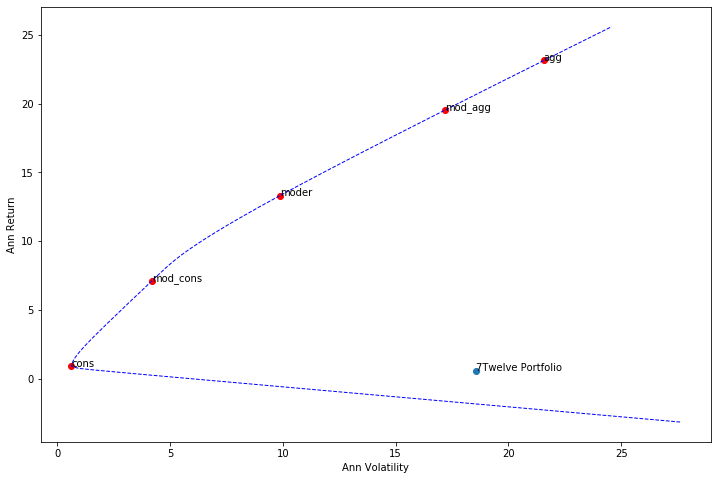

In [14]:
portfolio = '7Twelve Portfolio'
etfs = port_alloc_dict[portfolio]['etfs']
risk_levels = ['cons', 'mod_cons', 'moder', 'mod_agg', 'agg']
date = pd.to_datetime('2010-01-31')
history = etf_monthly_history[etf_monthly_history.index < date][etfs]*100

demo_frontier = EffFrontier(
    history, etf_predictions.loc[date, etfs]*100, risk_free=risk_free, exp_freq='M')
five_ports = demo_frontier.generate_five_levels().reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 8))
ax = plt.scatter(x=five_ports['volatility'], y=five_ports['return'], color='r')
for i, txt in enumerate(risk_levels):
    plt.annotate(txt, (five_ports['volatility'][i], five_ports['return'][i]))

ax = plt.plot(demo_frontier.frontier['volatility'],
              demo_frontier.frontier['return'], 'b--', linewidth=1)

port_returns = (
    history*port_alloc_dict[portfolio]['weights']).dropna(how='any').sum(axis=1)
port_vol = port_returns.std()*(np.sqrt(12))
port_exp_return = (etf_predictions.loc[date, etfs]*pd.Series(port_alloc_dict[portfolio]
                                                             ['weights'], index=etfs)).dropna(how='any').sum()*100

ax = plt.scatter(x=port_vol, y=port_exp_return)
plt.annotate(portfolio, (port_vol, port_exp_return))

plt.ylabel('Ann Return')
plt.xlabel('Ann Volatility')

plt.show()

The optimized allocations change each month based on historical covariances expected returns. To illustrate the differences in weights, the below chart shows the average allocations for one of the optimized portfolios for each of the calendar years in the analysis. The aggressive portfolio, which takes the optimized weights at the 90th percentile of the frontier volatility range, favors real-estate and small-caps until 2018. At that point, it begins to be weighted more toward mid-cap issues. SPY, the US large cap portion of the portfolio, does not see a significant allocation in any year. 

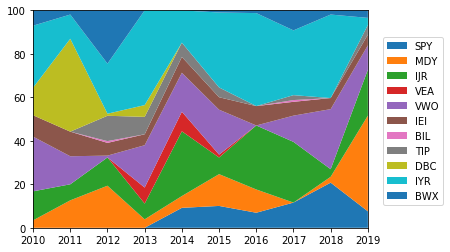

In [15]:
stack_data = eff_weights.loc[(slice(None),'agg'),portfolio]

plt.stackplot(stack_data.index.levels[0].year.unique(),stack_data.groupby(pd.Grouper(level='date', freq='Y')).mean().T*100)
plt.legend(stack_data.columns, bbox_to_anchor=(1.24,.9))
plt.margins(0)
plt.show()

This helper function uses the PortStats class to generate summary performance statistics to aid in evaluation.

In [16]:
def get_stats(history, benchmark, risk_free):
    stats = {}
    for port in history.columns:
        port_dict = {}
        port_stats = PortStats(history[port], benchmark, risk_free)
        port_dict['Return'] = port_stats.calc_ann_return()
        port_dict['Ann Volatility'] = port_stats.calc_vol()
        port_dict['Sharpe Ratio'] = port_stats.calc_sharpe()
        port_dict['Sortino Ratio'] = port_stats.calc_sortino()
        port_dict['Max Drawdown'] = port_stats.calc_max_dd()
        port_dict['Beta vs VTI'] = port_stats.calc_beta()
        port_dict['Ann Alpha vs VTI'] = port_stats.calc_alpha()
        stats[port] = port_dict
    return pd.DataFrame(data=stats)

The generated dataframe helps evaluate performance over the decade used in this analysis. The aggressive allocation outperformed on an absolute basis. On a risk-adjusted basis, the moderately conservative allocation delivers superior performance according to the Sharpe and Sortino ratios. The 7Twelve Portfolio also had the highest drawdown over the period.

The evaluations here and later in the analysis include VTI as a performance benchmark for beta and alpha computations. This is for consistency across comparisons. Relative performance evaluation would use more appropriate benchmarks for each portfolio.

In [18]:
benchmark = etf_monthly_history['VTI'].mul(100)
values = port_alloc_dict['7Twelve Portfolio']
portfolio = '7Twelve Portfolio'

etfs = values['etfs']
eff_port_returns = (
    eff_weights[portfolio]*etf_monthly_history[etfs]).sum(axis=1).mul(100)
port_returns = (etf_monthly_history[etfs]*pd.Series(data=values['weights'],index=values['etfs'])).dropna(how='any').sum(axis=1).mul(100).rename(portfolio)
all_returns = eff_port_returns.unstack()[risk_levels].merge(
    port_returns, how='inner', left_index=True, right_index=True)
df = get_stats(all_returns, benchmark=benchmark,
          risk_free=risk_free).style.highlight_max(axis=1)
df

,cons,mod_cons,moder,mod_agg,agg,7Twelve Portfolio
Return,0.473135,2.253933,2.914901,4.815841,6.205143,5.264617
Ann Volatility,0.245869,2.997796,5.918062,10.008557,13.064113,8.865749
Sharpe Ratio,-0.414137,0.560070,0.395390,0.423726,0.430966,0.528964
Sortino Ratio,-0.864009,0.543041,0.376803,0.403638,0.410023,0.504209
Max Drawdown,0.227186,4.840646,8.710007,10.200515,13.995036,15.107868
Beta vs VTI,0.004142,0.098488,0.303849,0.600600,0.809226,0.621404
Ann Alpha vs VTI,-0.154800,0.429631,-1.448287,-3.122506,-4.144259,-3.068629


## Evaluating Optimizations of All Portfolios

We repeat the analysis for all portfolios below and show the performance evaluation in bar charts.

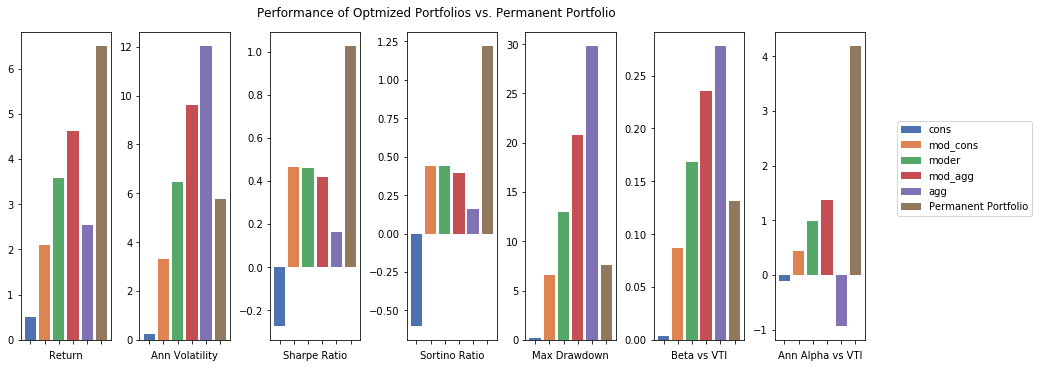

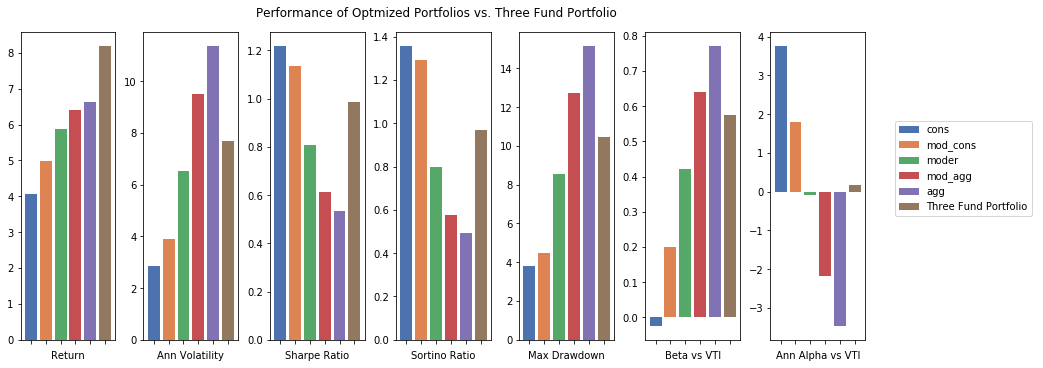

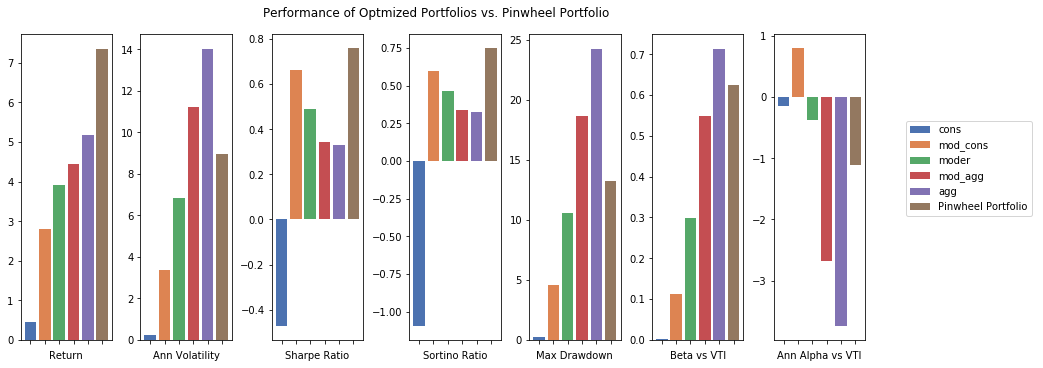

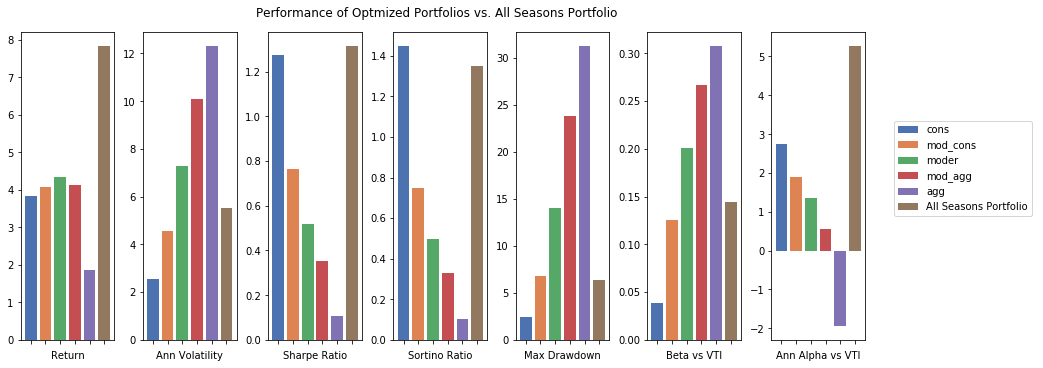

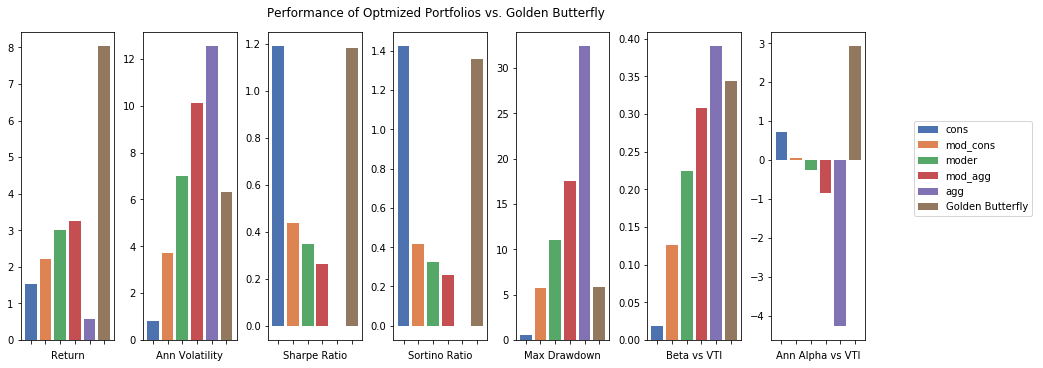

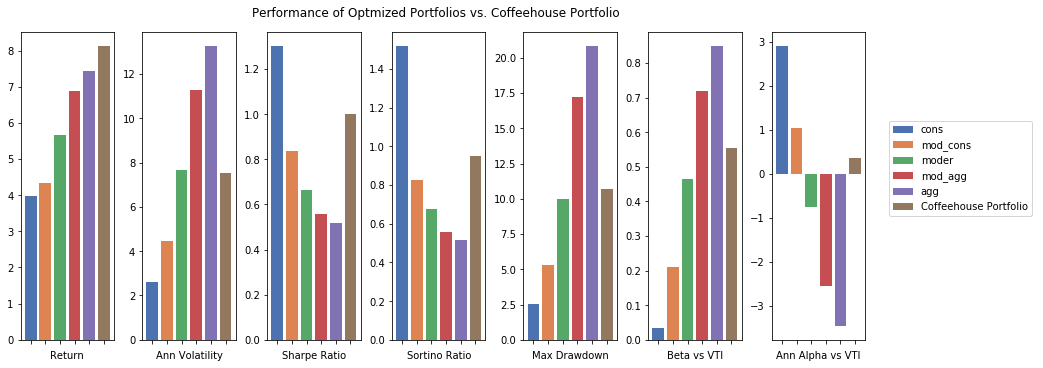

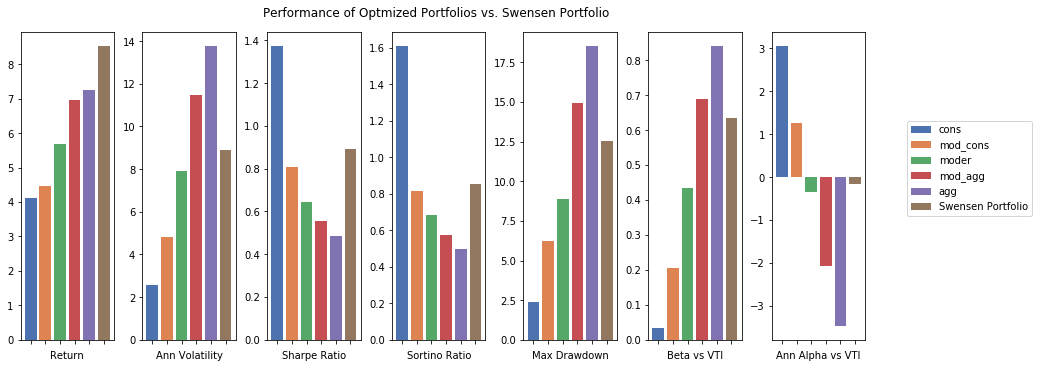

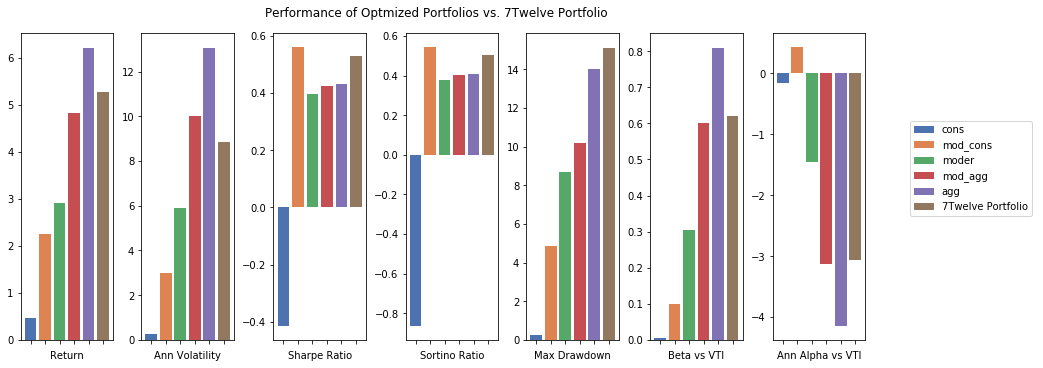

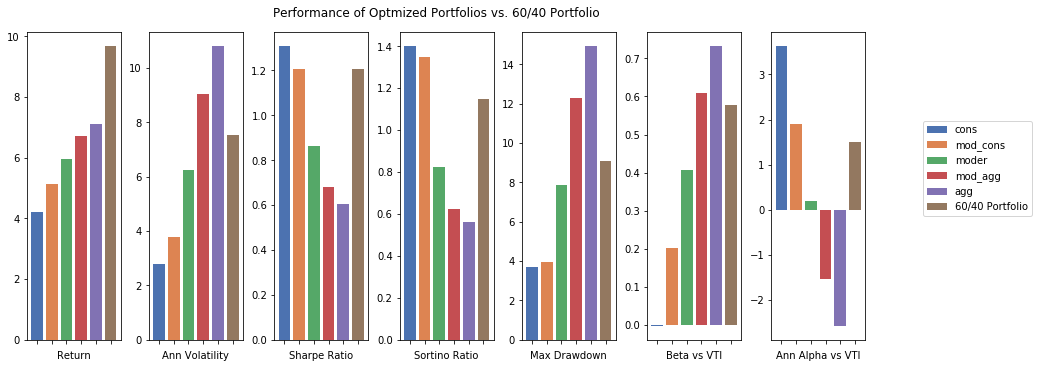

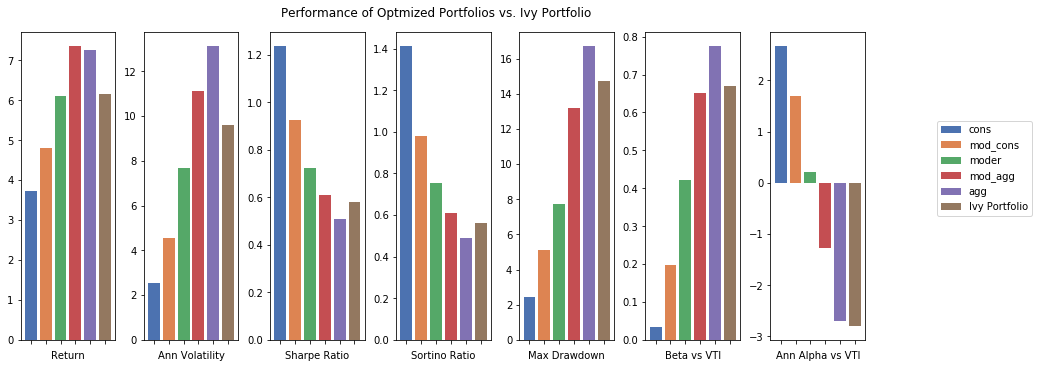

In [19]:
benchmark = etf_monthly_history['VTI'].mul(100)

for portfolio, values in port_alloc_dict.items():
    etfs = values['etfs']
    eff_port_returns = (
        eff_weights[portfolio]*etf_monthly_history[etfs]).sum(axis=1).mul(100)
    port_returns = (etf_monthly_history[etfs]*pd.Series(data=values['weights'],
                                                        index=values['etfs'])).dropna(how='any').sum(axis=1).mul(100).rename(portfolio)
    all_returns = eff_port_returns.unstack()[risk_levels].merge(
        port_returns, how='inner', left_index=True, right_index=True)
    stat_df = get_stats(all_returns, benchmark=benchmark,
                   risk_free=risk_free)
    fig, ax = plt.subplots(1,len(stat_df), figsize=(12,5), sharey=False, constrained_layout=True)
    for i in range(len(stat_df)):
        ax[i].bar(x=stat_df.columns,height=stat_df.iloc[i],color = colors)
        ax[i].set_xlabel(stat_df.index[i])
        ax[i].set_xticklabels('')
    handles, labels = ax[i].get_legend_handles_labels()
    fig.legend(ax[i].get_children(), stat_df.columns.to_list(), bbox_to_anchor=(1.2,.7))
    fig.suptitle('Performance of Optmized Portfolios vs. {}'.format(portfolio))
    plt.show()


On an absolute basis, the static allocations outperformed for all portfolios except the 7Twelve Portfolio and the Ivy Portfolio. It should be noted that the analysis is period dependent. The heavy US equity allocations would inevitably outperform during one of the longest equity bull markets in history. However, this does illustrate a limitation of mean-variance optimization. The optimized portfolios use limited histories of the ETFs and favor portfolios with lower covariances. For the equity-heavy allocations, the optimized counterparts would use favor commodities, real estate, and credit instruments. This begins to change as the forecasted positive returns outweigh the high covariances (typically around 2014). But the static allocations have had years of outperformance at that point.

On a risk-adjusted basis, atleast one of the optimized portfolios outperformed except for the All Seasons Portfolio, the Pinwheel Portfolio, and the Permanent Portfolio. These static allocations have higher credit and commodity allocations, particularly treasuries, so risk adjusted measures favor them. In the other cases, the point of the mean-variance optimization is to provide superior risk-adjusted performance, so it makes sense that the optimized portfolios were superior in this regard.

# Optimization Using All ETFs

What if we apply mean-variance optimization to all ETFs used by the Portfolio Charts allocations? The below cells show this.

In [20]:
eff_port_all = pd.read_csv('Data\eff_port_returns_all.csv').set_index('date',drop=True)
eff_port_all

,agg,cons,mod_agg,mod_cons,moder
date,,,,,
2010-01-31,1.677810,-0.021031,1.163511,0.506092,1.002771
2010-02-28,4.950414,-0.005435,4.129976,0.875300,2.403548
2010-03-31,0.142611,0.036375,0.063291,0.070629,-0.035868
2010-04-30,-1.929014,-0.053239,-0.662787,0.131627,0.031475
2010-05-31,0.647064,-0.009056,0.563669,0.338893,0.685491
...,...,...,...,...,...
2019-08-31,0.089833,0.173742,1.828798,0.723567,1.276116
2019-09-30,-0.225194,0.170705,-0.160104,0.060568,-0.047901
2019-10-31,2.849978,0.170605,2.319017,0.626612,1.396823


In [21]:
port_list = []
benchmark = etf_monthly_history['VTI'].mul(100)

for portfolio, values in port_alloc_dict.items():
    port_returns = (etf_monthly_history[values['etfs']]*pd.Series(data=values['weights'],
                                                    index=values['etfs'])).dropna(how='any').sum(axis=1).mul(100).rename(portfolio)
    port_list.append(port_returns)
    
all_port_returns = pd.concat(port_list, axis=1)
all_returns = eff_port_all[risk_levels].merge(
        all_port_returns, how='inner', left_index=True, right_index=True)
    
stat_df = get_stats(all_returns, benchmark=benchmark,
                   risk_free=risk_free).T.style.highlight_max(axis=0)
stat_df

,Return,Ann Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Beta vs VTI,Ann Alpha vs VTI
cons,0.509098,0.244190,-0.269711,-0.598975,0.140686,0.003640,-0.112514
mod_cons,1.770778,1.745782,0.684976,0.599234,2.459124,0.042143,0.653623
moder,3.581818,3.860405,0.778898,0.702364,6.240184,0.090157,1.860033
mod_agg,5.195670,6.737332,0.685837,0.690307,9.958811,0.184315,2.345853
agg,6.267070,9.675145,0.588323,0.623555,16.247219,0.333705,1.670157
Permanent Portfolio,6.490181,5.755881,1.027683,1.221340,7.611076,0.131720,4.192878
Three Fund Portfolio,8.175877,7.709480,0.985918,0.966581,10.464952,0.575615,0.169739
Pinwheel Portfolio,7.352959,8.936629,0.758452,0.748580,13.204672,0.623477,-1.116119
All Seasons Portfolio,7.824157,5.521941,1.312799,1.349641,6.333802,0.143985,5.273986
Golden Butterfly,8.026160,6.305303,1.181736,1.358125,5.854339,0.343345,2.932103


The aggressive allocation of optimized portfolios, which had the highest absolute return, had the highest volatility and highest drawdowns of all portfolios but could not outperform most of the static portfolios. One of the static allocations outperformed the optimized portfolios on absolute and relative terms, with equity-heavy allocations again shining. The 60/40 Portfolio, using VTI and AGG, almost tops the rankings for both measures. This makes sense given the time period. The All Seasons Portfolio is an exception to this analysis - it favors treasuries and performed admirably in both absolute and relative terms. 

# Discussion and Next Steps

This project explored the combination of time series forecasting through KNN and mean-variance optimization. The results, when compared with static allocations recommended across various publications, are mixed. Backtested portfolios tended to outperform on a risk-adjusted basis if using the same investments as the static portfolio, which speaks to the effectiveness of the mean-variance framework. 

Should investors flock to machine learning instead of using "set and forget" allocations? Not quite yet. The previous analysis of KNN for longer-period forecasts noted that it performs well on time series with higher autocorrelations. For volatile securites, such as real estate and small cap equity, KNN forecasts are not reliable. Optimization also performs well with more data. This analysis is limited by the availability of free data, so longer historical time series would benefit predictions. 

This project does illustrate the possiblities of a pipeline. The forecasting capabilities of machine learning, here executed with KNN, can be executed by other approaches - ensemble methods, boosting algorithms, or deep learning, for example. The forecasts can then be fed into the optimization procedure.